# Using SVR to predict Forest Fires

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Read the dataset

In [4]:
df = pd.read_csv('forestfires.csv')
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


### Basic statistics and visualization of the dataset

#### Describe the statistics of numerical columns

In [5]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


#### Plot scatterplots and distributions of numerical features to see how they may affect the output 'area'

For this, first we need to transform the outcome 'area' by taking its logarithm (after adding 1 to avoid zeros)

$$\text{Log-area} = log_{10}(area+1)$$

In [6]:
df['Log-area']=np.log10(df['area']+1)

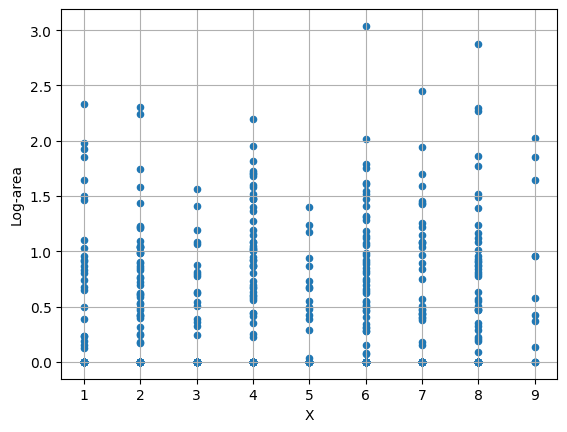

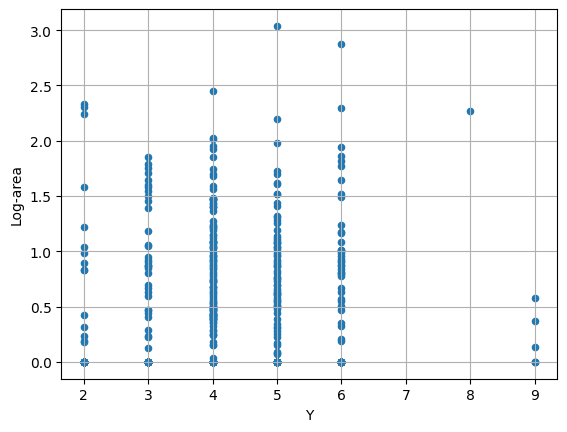

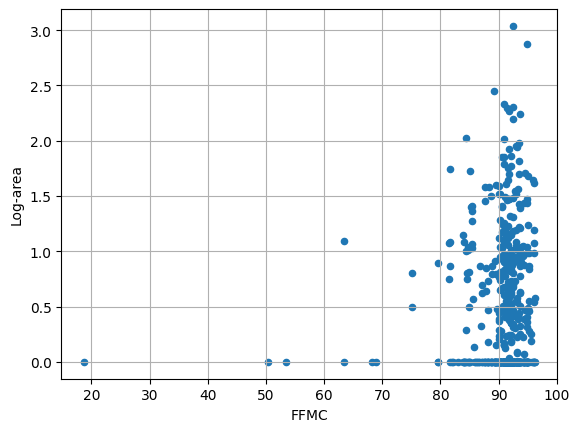

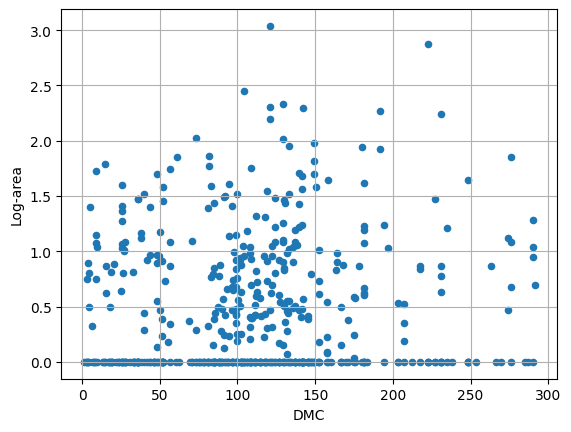

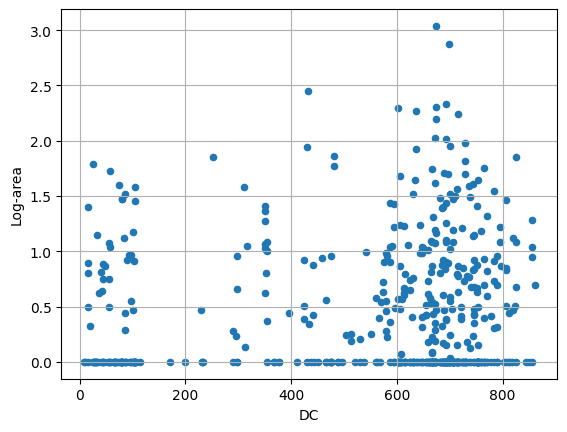

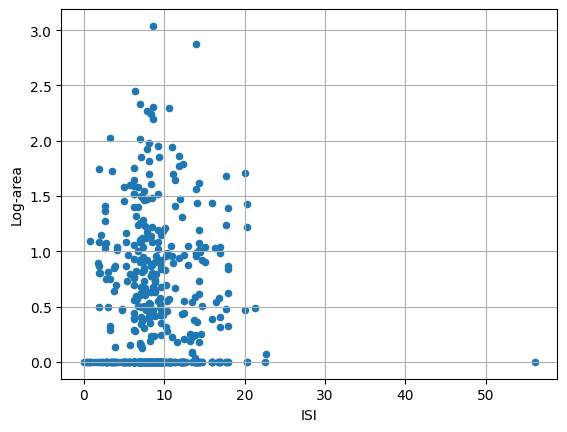

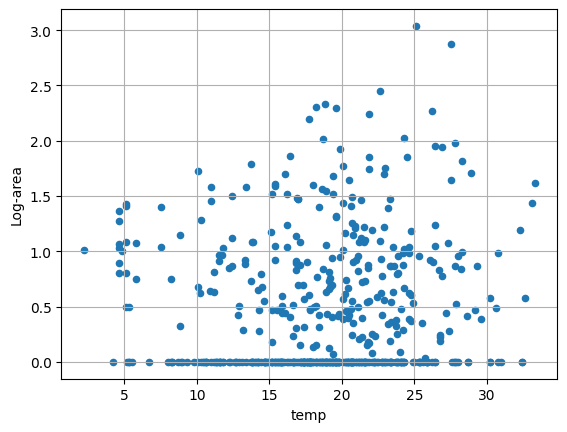

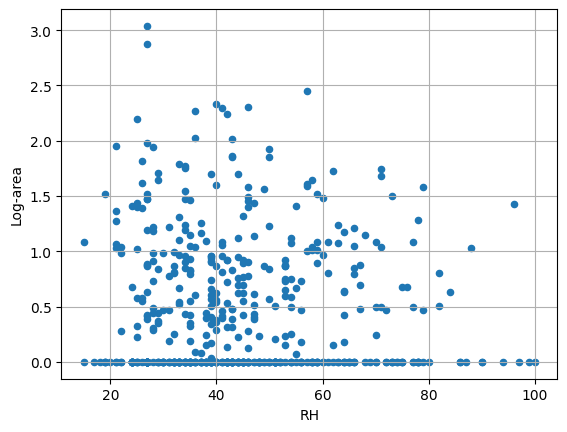

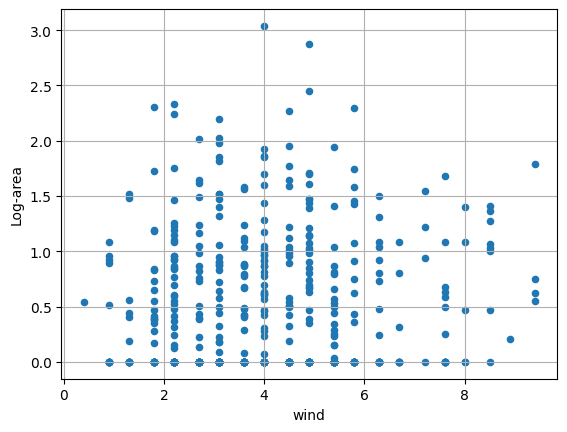

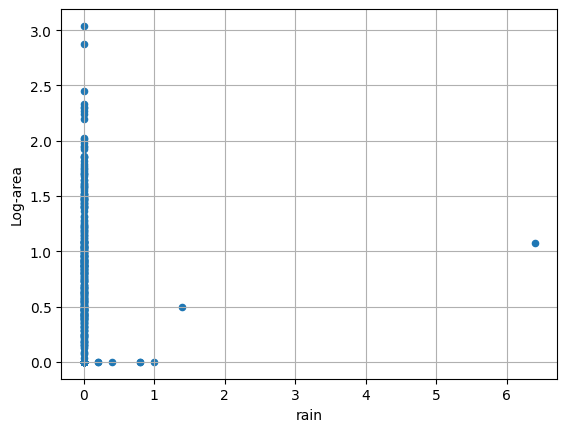

In [7]:
for i in df.describe().columns[:-2]:
    df.plot.scatter(i,'Log-area',grid=True)

#### Plot boxplots of how the categorical features (month and day) affect the outcome

<Axes: title={'center': 'Log-area'}, xlabel='day'>

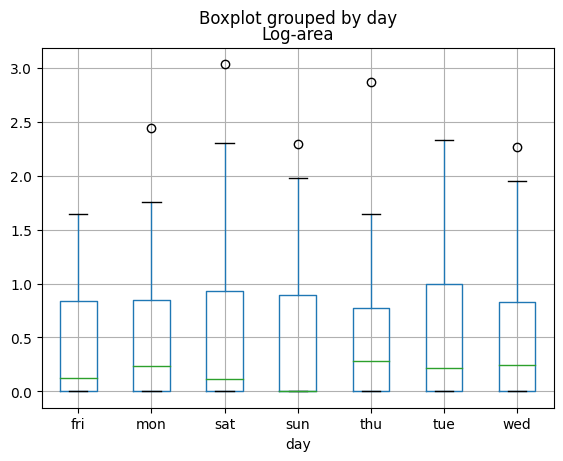

In [8]:
df.boxplot(column='Log-area',by='day')

<Axes: title={'center': 'Log-area'}, xlabel='month'>

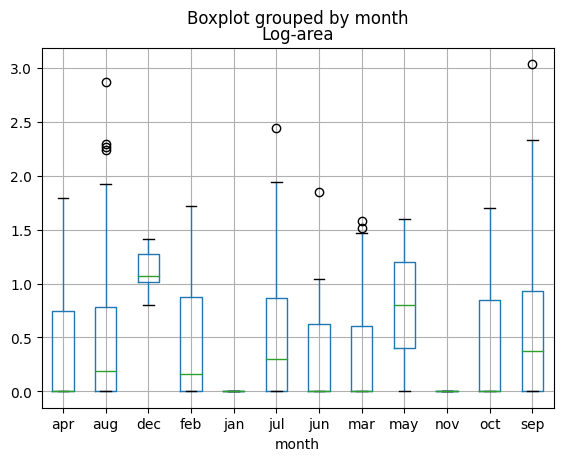

In [9]:
df.boxplot(column='Log-area',by='month')

## Data pre-processing, test/train split, REC function

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

#### Label encoder for the categorical feature (_day_ and _month_)

In [11]:
enc = LabelEncoder()
enc.fit(df['month'])

LabelEncoder()

In [12]:
enc.classes_

array(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may',
       'nov', 'oct', 'sep'], dtype=object)

In [13]:
df['month_encoded']=enc.transform(df['month'])
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,Log-area,month_encoded
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0.0,7
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0.0,10
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0.0,10
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0.0,7
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0.0,7


In [14]:
enc.fit(df['day'])

LabelEncoder()

In [15]:
enc.classes_

array(['fri', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed'], dtype=object)

In [16]:
df['day_encoded']=enc.transform(df['day'])
df.head(15)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,Log-area,month_encoded,day_encoded
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0.0,7,0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0.0,10,5
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0.0,10,2
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0.0,7,0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0.0,7,3
5,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0,0.0,1,3
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0,0.0,1,1
7,8,6,aug,mon,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0,0.0,1,1
8,8,6,sep,tue,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.0,0.0,11,5
9,7,5,sep,sat,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,0.0,0.0,11,2


#### Test set fraction

In [17]:
test_size=0.4

#### Test/train split

In [18]:
X_data=df.drop(['area','Log-area','month','day'],axis=1)
y_data=df['Log-area']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

In [19]:
y_train_array = np.array(y_train)
y_train_array = y_train_array.reshape(y_train_array.size, 1)

### Regression Error Characteristic (REC) estimation

Receiver Operating Characteristic (ROC) curves provide a powerful tool for visualizing and comparing classification results. Regression Error Characteristic (REC) curves generalize ROC curves to regression. REC curves plot the error tolerance on the $x-axis$ versus the percentage of points predicted within the tolerance on the $y-axis$. The resulting
curve estimates the cumulative distribution function of the error. The REC curve visually presents commonly-useds tatistics. The area-over-the-curve (AOC) is a biased estimate of the expected error. The $R^2$ value can be estimated using the ratio of the AOC for a given model to the AOC for the nul-model. Users can quickly assess the relative
merits of many regression functions by examining the relative position of their REC curves. The shape of the curve reveals additional information that can be used to guide modeling.

[Check this paper for more details](https://www.aaai.org/Papers/ICML/2003/ICML03-009.pdf)

In [20]:
def rec(m,n,tol):
    if type(m)!='numpy.ndarray':
        m=np.array(m)
    if type(n)!='numpy.ndarray':
        n=np.array(n)
    l=m.size
    percent = 0
    for i in range(l):
        if np.abs(10**m[i]-10**n[i])<=tol:
            percent+=1
    return 100*(percent/l)

In [21]:
# Define the max tolerance limit for REC curve x-axis
# For this problem this represents the absolute value of error in the prediction of the outcome i.e. area burned
tol_max=20

## Gridsearch

Finding the right parameters  for machine learning models is a tricky task! But luckily, Scikit-learn has the functionality of trying a bunch of combinations and see what works best, built in with GridSearchCV! The CV stands for cross-validation.

**GridSearchCV takes a dictionary that describes the parameters that should be tried and a model to train. The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested.**

## Support Vector Regressor (SVR)

In [22]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [23]:
scaler = StandardScaler()

In [24]:
# Assuming y_train is a Pandas Series, convert it to a NumPy array and then reshape it
y_train_array = np.array(y_train)
y_train_array = y_train_array.reshape(-1, 1)

# Fit and transform X_train and y_train with the scaler
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(y_train_array)

In [25]:
# Parameter grid for the Grid Search
param_grid = {'C': [0.01,0.1,1, 10], 'kernel': ['linear', 'rbf']}

In [26]:
# Create the GridSearchCV object
grid_SVR = GridSearchCV(SVR(), param_grid, refit=True, verbose=0, cv=5)

# Fit the model with scaled data
grid_SVR.fit(X_train_scaled, y_train_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']})

In [27]:
print("Best parameters obtained by Grid Search:",grid_SVR.best_params_)

Best parameters obtained by Grid Search: {'C': 1, 'kernel': 'rbf'}


In [28]:
a=grid_SVR.predict(X_test)
print("RMSE for Support Vector Regression:",np.sqrt(np.mean((y_test-a)**2)))

RMSE for Support Vector Regression: 0.8391593884193752


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


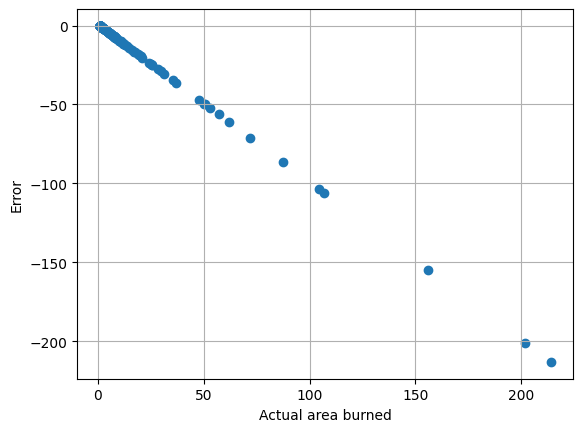

In [29]:
plt.xlabel("Actual area burned")
plt.ylabel("Error")
plt.grid(True)
plt.scatter(10**(y_test),10**(a)-10**(y_test))

(array([  1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.,   0.,   1.,   1.,   1.,   2.,   1.,   0.,   2.,   1.,   2.,
          4.,   4.,   4.,  10.,  26., 141.]),
 array([-213.11847108, -208.86087108, -204.60327108, -200.34567108,
        -196.08807108, -191.83047108, -187.57287108, -183.31527108,
        -179.05767108, -174.80007108, -170.54247108, -166.28487108,
        -162.02727108, -157.76967108, -153.51207108, -149.25447108,
        -144.99687108, -140.73927108, -136.48167108, -132.22407108,
        -127.96647108, -123.70887108, -119.45127108, -115.19367108,
        -110.93607108, -106.67847108, -102.42087108,  -98.16327108,
         -93.90567108,  -89.64807108,  -85.39047108,  -81.13287108,
         -76.87527108,  -72.61767108,  -68.36007108,  -64.10247108,
         -59.84487108,  -55.58727108,  -51.329

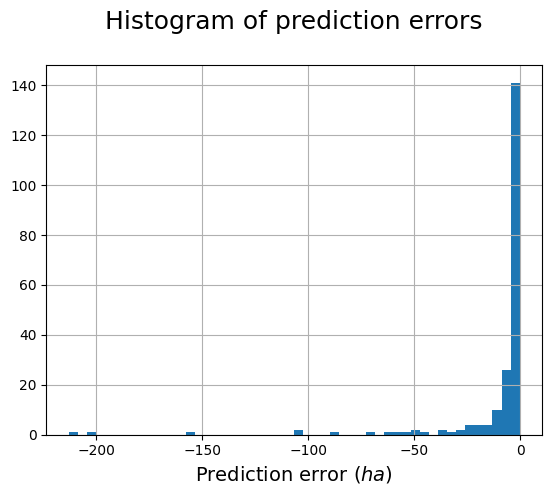

In [30]:
plt.title("Histogram of prediction errors\n",fontsize=18)
plt.xlabel("Prediction error ($ha$)",fontsize=14)
plt.grid(True)
plt.hist(10**(a.reshape(a.size,))-10**(y_test),bins=50)

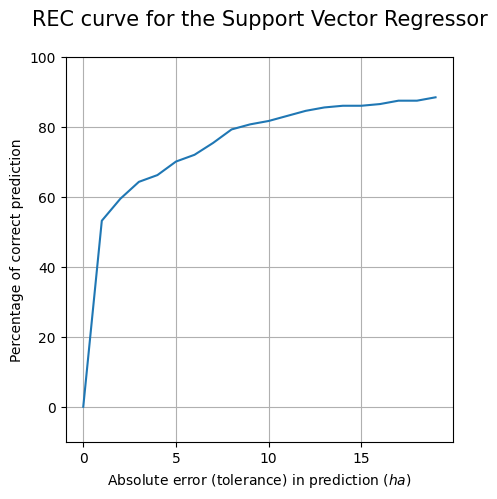

In [31]:
rec_SVR=[]
for i in range(tol_max):
    rec_SVR.append(rec(a,y_test,i))

plt.figure(figsize=(5,5))
plt.title("REC curve for the Support Vector Regressor\n",fontsize=15)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i*5 for i in range(tol_max+1)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_SVR)

## Prediction using Descision Tree Regressor

In [32]:
from sklearn.tree import DecisionTreeRegressor

In [33]:
tree_model = DecisionTreeRegressor(max_depth=10,criterion='squared_error')
tree_model.fit(X_train_scaled, y_train_scaled)

DecisionTreeRegressor(max_depth=10)

In [34]:
a=tree_model.predict(X_test)
print("RMSE for Decision Tree:",np.sqrt(np.mean((y_test-a)**2)))

RMSE for Decision Tree: 1.0629031004953613


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [35]:
from sklearn.metrics import mean_squared_error

a = tree_model.predict(X_test)
mse = mean_squared_error(y_test, a)
print("MSE for Decision Tree:", mse)

MSE for Decision Tree: 1.129763001042652


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


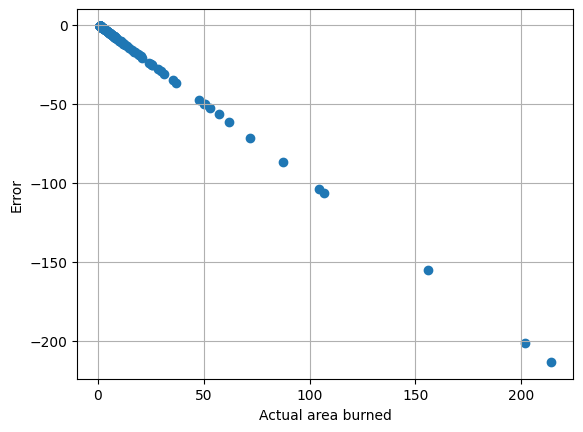

In [36]:
plt.xlabel("Actual area burned")
plt.ylabel("Error")
plt.grid(True)
plt.scatter(10**(y_test),10**(a)-10**(y_test))

(array([  1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.,   0.,   1.,   1.,   1.,   2.,   1.,   0.,   2.,   1.,   2.,
          4.,   4.,   4.,  10.,  26., 141.]),
 array([-213.47847281, -209.22087281, -204.96327281, -200.70567281,
        -196.44807281, -192.19047281, -187.93287281, -183.67527281,
        -179.41767281, -175.16007281, -170.90247281, -166.64487281,
        -162.38727281, -158.12967281, -153.87207281, -149.61447281,
        -145.35687281, -141.09927281, -136.84167281, -132.58407281,
        -128.32647281, -124.06887281, -119.81127281, -115.55367281,
        -111.29607281, -107.03847281, -102.78087281,  -98.52327281,
         -94.26567281,  -90.00807281,  -85.75047281,  -81.49287281,
         -77.23527281,  -72.97767281,  -68.72007281,  -64.46247281,
         -60.20487281,  -55.94727281,  -51.689

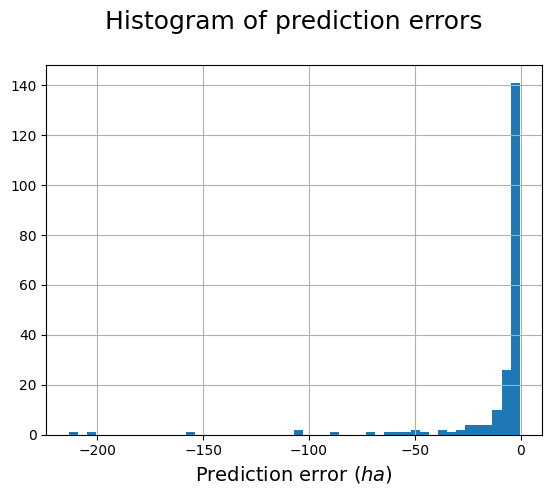

In [37]:
plt.title("Histogram of prediction errors\n",fontsize=18)
plt.xlabel("Prediction error ($ha$)",fontsize=14)
plt.grid(True)
plt.hist(10**(a.reshape(a.size,))-10**(y_test),bins=50)

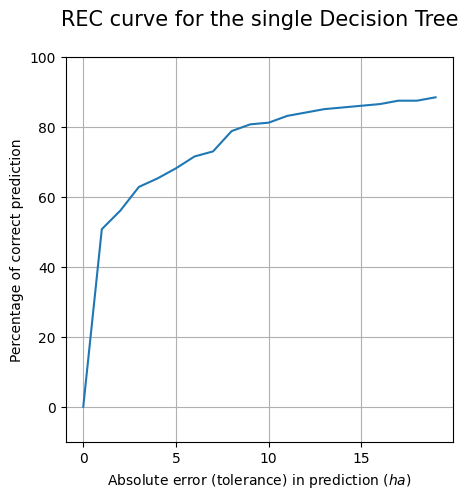

In [38]:
rec_DT=[]
for i in range(tol_max):
    rec_DT.append(rec(a,y_test,i))

plt.figure(figsize=(5,5))
plt.title("REC curve for the single Decision Tree\n",fontsize=15)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i for i in range(0,tol_max+1,5)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_DT)

Random Forest Regressor

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
param_grid = {'max_depth': [5,10,15,20,50], 'max_leaf_nodes': [2,5,10], 'min_samples_leaf': [2,5,10],
             'min_samples_split':[2,5,10]}
grid_RF = GridSearchCV(RandomForestRegressor(),param_grid,refit=True,verbose=0,cv=5)
grid_RF.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15, 20, 50],
                         'max_leaf_nodes': [2, 5, 10],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [2, 5, 10]})

In [41]:
print("Best parameters obtained by Grid Search:",grid_RF.best_params_)

Best parameters obtained by Grid Search: {'max_depth': 50, 'max_leaf_nodes': 2, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [42]:
a=grid_RF.predict(X_test)
rmse_rf=np.sqrt(np.mean((y_test-a)**2))
print("RMSE for Random Forest:",rmse_rf)

RMSE for Random Forest: 0.599613372773983


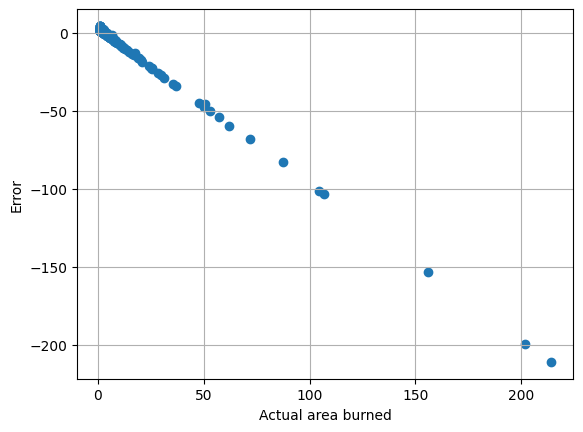

In [43]:
plt.xlabel("Actual area burned")
plt.ylabel("Error")
plt.grid(True)
plt.scatter(10**(y_test),10**(a)-10**(y_test))

(array([  1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.,   0.,   1.,   1.,   2.,   2.,   0.,   0.,   2.,   3.,   3.,
          3.,   5.,   6.,  19.,  30., 123.]),
 array([-210.99636023, -206.6845865 , -202.37281276, -198.06103903,
        -193.74926529, -189.43749156, -185.12571782, -180.81394409,
        -176.50217035, -172.19039662, -167.87862288, -163.56684915,
        -159.25507541, -154.94330168, -150.63152794, -146.31975421,
        -142.00798047, -137.69620674, -133.384433  , -129.07265927,
        -124.76088554, -120.4491118 , -116.13733807, -111.82556433,
        -107.5137906 , -103.20201686,  -98.89024313,  -94.57846939,
         -90.26669566,  -85.95492192,  -81.64314819,  -77.33137445,
         -73.01960072,  -68.70782698,  -64.39605325,  -60.08427951,
         -55.77250578,  -51.46073204,  -47.148

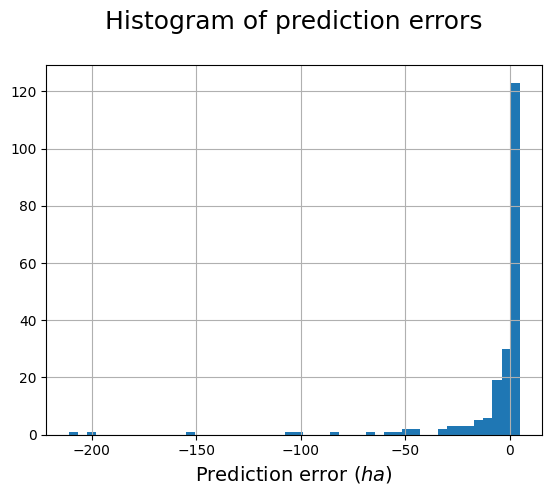

In [44]:
plt.title("Histogram of prediction errors\n",fontsize=18)
plt.xlabel("Prediction error ($ha$)",fontsize=14)
plt.grid(True)
plt.hist(10**(a.reshape(a.size,))-10**(y_test),bins=50)

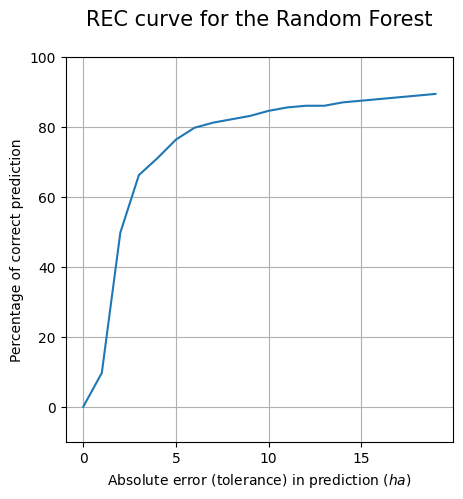

In [45]:
rec_RF=[]
for i in range(tol_max):
    rec_RF.append(rec(a,y_test,i))

plt.figure(figsize=(5,5))
plt.title("REC curve for the Random Forest\n",fontsize=15)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i for i in range(0,tol_max+1,5)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_RF)